In [ ]:
from datetime import datetime
import pytz
print('Tested',datetime.now(pytz.timezone('Asia/Calcutta')))

Tested 2024-01-07 00:35:45.743982+05:30


**INITIALIZING SPARK**

In [ ]:
!pip3 -q install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Arghya_ET_Assignment').master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


<SparkContext master=local[*] appName=Arghya_ET_Assignment>

In [ ]:
# Importing Necessary Libraries and Modules
import warnings
import pandas as pd
import seaborn as sns

# Suppress warnings to maintain a clean output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Configure Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# Using the wget command to download the dataset from a given URL
!wget -O cardekho_dataset.csv -q https://raw.githubusercontent.com/ArghyaRC/Cardekho_dataset/main/cardekho_dataset.csv

In [ ]:
#loading dataset into spark dataframe
df = spark.read.csv("cardekho_dataset.csv", header=True, inferSchema=True)
# df
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
spark = SparkSession.builder.appName('Praxis').getOrCreate()
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

In [ ]:
df.show(5)

+--------------------+----+-------------+---------+------+-----------+------------+------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|
+--------------------+----+-------------+---------+------+-----------+------------+------------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual| First Owner|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual| First Owner|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual| First Owner|
|Datsun RediGO T O...|2017|       250000|    46000|Petrol| Individual|      Manual| First Owner|
|Honda Amaze VX i-...|2014|       450000|   141000|Diesel| Individual|      Manual|Second Owner|
+--------------------+----+-------------+---------+------+-----------+------------+------------+
only showing top 5 rows



In [ ]:
# printing out the schema of our dataframe
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- selling_price: integer (nullable = true)
 |-- km_driven: integer (nullable = true)
 |-- fuel: string (nullable = true)
 |-- seller_type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- owner: string (nullable = true)



In [ ]:
df = df.withColumn("year", df["year"].cast('integer'))
df = df.withColumn("selling_price", df["selling_price"].cast('integer'))
df = df.withColumn("km_driven", df["km_driven"].cast('integer'))

In [ ]:
df.printSchema()

root
 |-- Car_Name: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- selling_price: integer (nullable = true)
 |-- Kms_Driven: integer (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Seller_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Owner: string (nullable = true)



In [ ]:
# checking for null values in the dataset

df.toPandas().isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

In [ ]:
# checking for cardinality in name
df.toPandas().value_counts('name')

name
Maruti Swift Dzire VDI                  69
Maruti Alto 800 LXI                     59
Maruti Alto LXi                         47
Hyundai EON Era Plus                    35
Maruti Alto LX                          35
                                        ..
Mahindra KUV 100 G80 K4 Plus             1
Mahindra KUV 100 mFALCON D75 K8          1
Mahindra KUV 100 mFALCON D75 K8 AW       1
Mahindra KUV 100 mFALCON G80 K2 Plus     1
Volvo XC60 D5 Inscription                1
Length: 1491, dtype: int64

In [ ]:
# checking for cardinality in seller
df.toPandas()['seller_type'].value_counts()

Individual          3244
Dealer               994
Trustmark Dealer     102
Name: seller_type, dtype: int64

In [ ]:
# checking for cardinality offerType
df.toPandas()['fuel'].value_counts()

Diesel      2153
Petrol      2123
CNG           40
LPG           23
Electric       1
Name: fuel, dtype: int64

In [ ]:
# checking for cardinality in transmission
df.toPandas()['owner'].value_counts()

First Owner             2832
Second Owner            1106
Third Owner              304
Fourth & Above Owner      81
Test Drive Car            17
Name: owner, dtype: int64

In [ ]:
# taking out the numeric features
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
numeric_features_df= df.select(numeric_features)
numeric_features_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
year,4340,2013.0907834101383,4.215343939724156,1992,2020
selling_price,4340,504127.3117511521,578548.7361388858,20000,8900000
km_driven,4340,66215.77741935484,46644.10219362085,1,806599


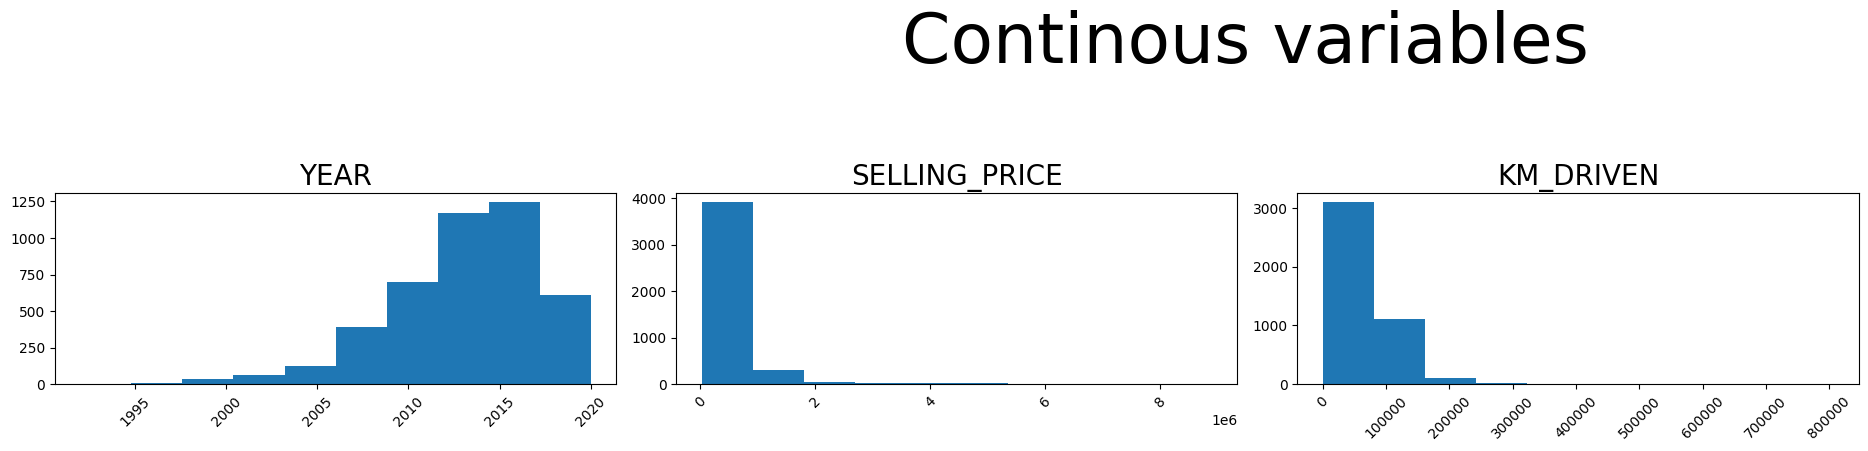

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(25,15)) ## Plot Size
st = fig.suptitle("Continous variables", fontsize=50,
                  verticalalignment='center') # Plot Main Title

for col,num in zip(df.toPandas().describe().columns, range(1,17)):
    ax = fig.add_subplot(5,4,num)
    ax.hist(df.toPandas()[col])

    plt.grid(False)
    plt.xticks(rotation=45,fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

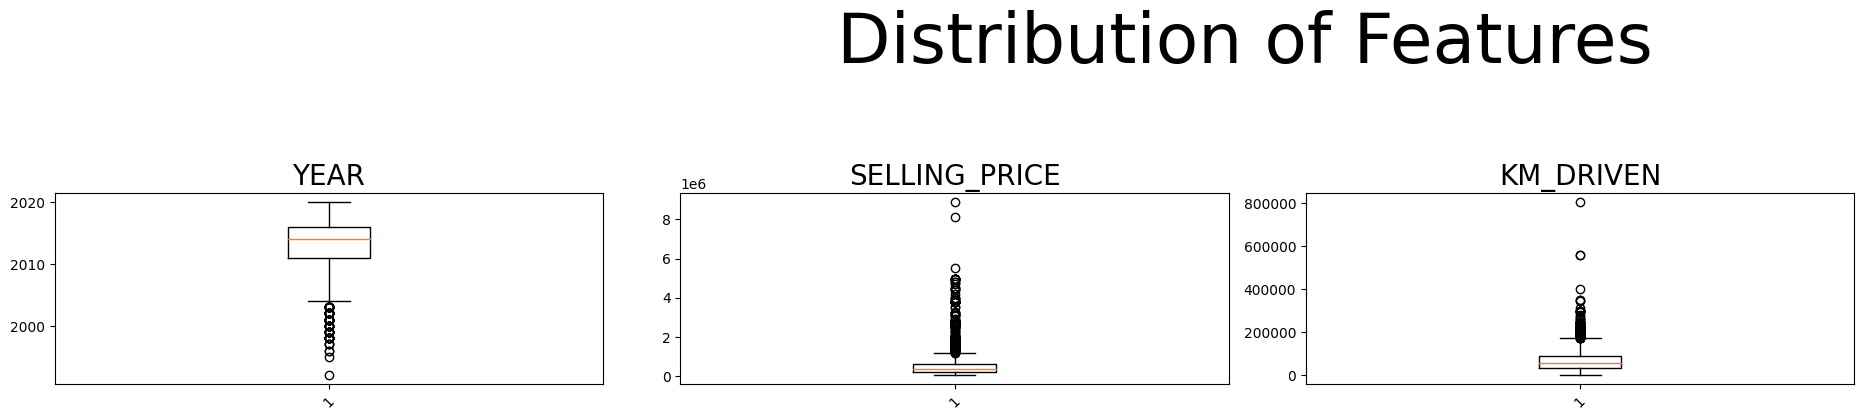

In [ ]:
fig = plt.figure(figsize=(25,15)) ## Plot Size
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title

for col,num in zip(df.toPandas().describe().columns, range(1,17)):
    ax = fig.add_subplot(5,4,num)
    ax.boxplot(df.toPandas()[col])

    plt.grid(False)
    plt.xticks(rotation=45,fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [ ]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,year,selling_price,km_driven
year,1.00,0.41,-0.42
selling_price,0.41,1.00,-0.19
km_driven,-0.42,-0.19,1.00


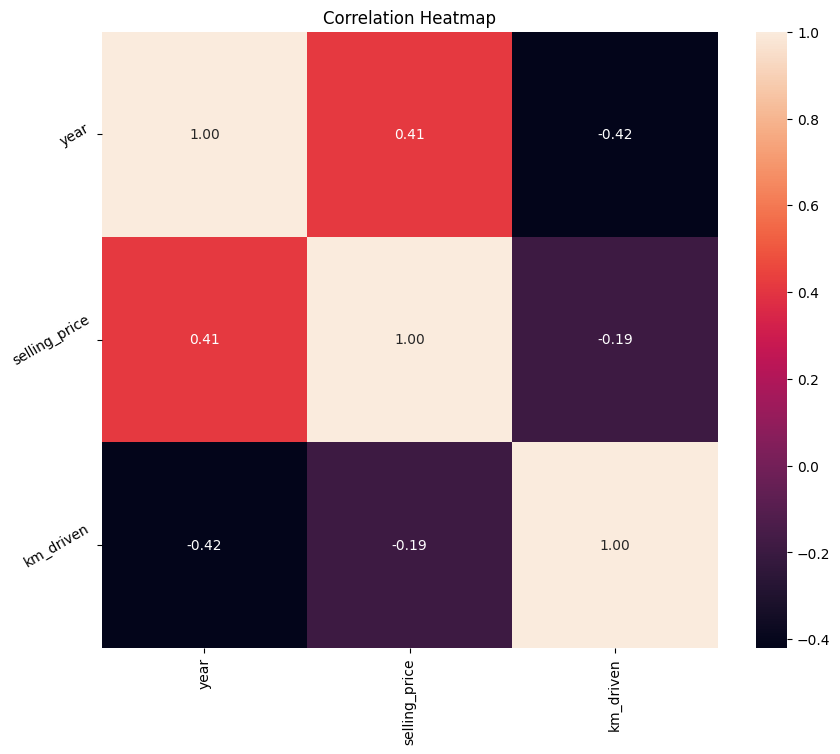

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
plt.title('Correlation Heatmap')
ax = sns.heatmap(corr_df, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

**FROM THE ABOVE HEATMAP WE CAN SEE THAT THERE IS NOT MUCH CORRELATION BETWEEN OUR INDEPENDENT VARIABLES. SO THERE IS NOT MUCH MULTICOLLINEARITY IN OUR DATASET**

**String Indexer**

In [ ]:
nameIndexer = StringIndexer(inputCol="name", outputCol="nameIndex")
fuelIndexer = StringIndexer(inputCol="fuel", outputCol="fuelIndex")
seller_typeIndexer = StringIndexer(inputCol="seller_type", outputCol="seller_typeIndex")
transmissionIndexer = StringIndexer(inputCol="transmission", outputCol="transmissionIndex")
ownerIndexer = StringIndexer(inputCol="owner", outputCol="ownerIndex")

In [ ]:
nameIndexer.fit(df).transform(df).show(5)

+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|nameIndex|
+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual| First Owner|     10.0|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual| First Owner|      9.0|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual| First Owner|     25.0|
|Datsun RediGO T O...|2017|       250000|    46000|Petrol| Individual|      Manual| First Owner|     99.0|
|Honda Amaze VX i-...|2014|       450000|   141000|Diesel| Individual|      Manual|Second Owner|     74.0|
+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+
only showing top 5 rows



In [ ]:
fuelIndexer.fit(df).transform(df).show(5)

+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|fuelIndex|
+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual| First Owner|      1.0|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual| First Owner|      1.0|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual| First Owner|      0.0|
|Datsun RediGO T O...|2017|       250000|    46000|Petrol| Individual|      Manual| First Owner|      1.0|
|Honda Amaze VX i-...|2014|       450000|   141000|Diesel| Individual|      Manual|Second Owner|      0.0|
+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+
only showing top 5 rows



In [ ]:
seller_typeIndexer.fit(df).transform(df).show(5)

+--------------------+----+-------------+---------+------+-----------+------------+------------+----------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|seller_typeIndex|
+--------------------+----+-------------+---------+------+-----------+------------+------------+----------------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual| First Owner|             0.0|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual| First Owner|             0.0|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual| First Owner|             0.0|
|Datsun RediGO T O...|2017|       250000|    46000|Petrol| Individual|      Manual| First Owner|             0.0|
|Honda Amaze VX i-...|2014|       450000|   141000|Diesel| Individual|      Manual|Second Owner|             0.0|
+--------------------+----+-------------+---------+------+-----------+------------+-----

In [ ]:
transmissionIndexer.fit(df).transform(df).show(5)

+--------------------+----+-------------+---------+------+-----------+------------+------------+-----------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|transmissionIndex|
+--------------------+----+-------------+---------+------+-----------+------------+------------+-----------------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual| First Owner|              0.0|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual| First Owner|              0.0|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual| First Owner|              0.0|
|Datsun RediGO T O...|2017|       250000|    46000|Petrol| Individual|      Manual| First Owner|              0.0|
|Honda Amaze VX i-...|2014|       450000|   141000|Diesel| Individual|      Manual|Second Owner|              0.0|
+--------------------+----+-------------+---------+------+-----------+----------

In [ ]:
ownerIndexer.fit(df).transform(df).show(5)

+--------------------+----+-------------+---------+------+-----------+------------+------------+----------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|ownerIndex|
+--------------------+----+-------------+---------+------+-----------+------------+------------+----------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual| First Owner|       0.0|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual| First Owner|       0.0|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual| First Owner|       0.0|
|Datsun RediGO T O...|2017|       250000|    46000|Petrol| Individual|      Manual| First Owner|       0.0|
|Honda Amaze VX i-...|2014|       450000|   141000|Diesel| Individual|      Manual|Second Owner|       1.0|
+--------------------+----+-------------+---------+------+-----------+------------+------------+----------+
only showing top 5 rows



**One Hot Encoder**

In [ ]:
OHE_name = OneHotEncoder(inputCol="nameIndex", outputCol="nameVec")
OHE_fuel = OneHotEncoder(inputCol="fuelIndex", outputCol="fuelVec")
OHE_sellertype = OneHotEncoder(inputCol="seller_typeIndex", outputCol="seller_typeVec")
OHE_transmission = OneHotEncoder(inputCol="transmissionIndex", outputCol="transmissionVec")
OHE_owner = OneHotEncoder(inputCol="ownerIndex", outputCol="ownerVec")

In [ ]:
OHE_name.fit(nameIndexer.fit(df).transform(df)).transform(nameIndexer.fit(df).transform(df)).show(3)

+--------------------+----+-------------+---------+------+-----------+------------+-----------+---------+-----------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|      owner|nameIndex|          nameVec|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+---------+-----------------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual|First Owner|     10.0|(1490,[10],[1.0])|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual|First Owner|      9.0| (1490,[9],[1.0])|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual|First Owner|     25.0|(1490,[25],[1.0])|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+---------+-----------------+
only showing top 3 rows



In [ ]:
OHE_fuel.fit(fuelIndexer.fit(df).transform(df)).transform(fuelIndexer.fit(df).transform(df)).show(3)

+--------------------+----+-------------+---------+------+-----------+------------+-----------+---------+-------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|      owner|fuelIndex|      fuelVec|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+---------+-------------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual|First Owner|      1.0|(4,[1],[1.0])|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual|First Owner|      1.0|(4,[1],[1.0])|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual|First Owner|      0.0|(4,[0],[1.0])|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+---------+-------------+
only showing top 3 rows



In [ ]:
OHE_sellertype.fit(seller_typeIndexer.fit(df).transform(df)).transform(seller_typeIndexer.fit(df).transform(df)).show(3)

+--------------------+----+-------------+---------+------+-----------+------------+-----------+----------------+--------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|      owner|seller_typeIndex|seller_typeVec|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+----------------+--------------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual|First Owner|             0.0| (2,[0],[1.0])|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual|First Owner|             0.0| (2,[0],[1.0])|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual|First Owner|             0.0| (2,[0],[1.0])|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+----------------+--------------+
only showing top 3 rows



In [ ]:
OHE_transmission.fit(transmissionIndexer.fit(df).transform(df)).transform(transmissionIndexer.fit(df).transform(df)).show(3)

+--------------------+----+-------------+---------+------+-----------+------------+-----------+-----------------+---------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|      owner|transmissionIndex|transmissionVec|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+-----------------+---------------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual|First Owner|              0.0|  (1,[0],[1.0])|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual|First Owner|              0.0|  (1,[0],[1.0])|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual|First Owner|              0.0|  (1,[0],[1.0])|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+-----------------+---------------+
only showing top 3 rows



In [ ]:
OHE_owner.fit(ownerIndexer.fit(df).transform(df)).transform(ownerIndexer.fit(df).transform(df)).show(3)

+--------------------+----+-------------+---------+------+-----------+------------+-----------+----------+-------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|      owner|ownerIndex|     ownerVec|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+----------+-------------+
|       Maruti 800 AC|2007|        60000|    70000|Petrol| Individual|      Manual|First Owner|       0.0|(4,[0],[1.0])|
|Maruti Wagon R LX...|2007|       135000|    50000|Petrol| Individual|      Manual|First Owner|       0.0|(4,[0],[1.0])|
|Hyundai Verna 1.6 SX|2012|       600000|   100000|Diesel| Individual|      Manual|First Owner|       0.0|(4,[0],[1.0])|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+----------+-------------+
only showing top 3 rows



**Assembler**

In [ ]:
F_assembler = VectorAssembler(inputCols=['nameVec', 'year','km_driven', 'fuelVec', 'seller_typeVec', 'transmissionVec', 'ownerVec'],outputCol='features')

**Standard Scaler**

In [ ]:
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

**Creating the base pipeline**

In [ ]:
basePipe = Pipeline(stages=[nameIndexer, fuelIndexer, seller_typeIndexer, transmissionIndexer, ownerIndexer, OHE_name,OHE_fuel,OHE_sellertype,OHE_transmission,OHE_owner,F_assembler,standardScaler])


In [ ]:
df_transformed = basePipe.fit(df).transform(df)

**Train Test Split**

In [ ]:
train_df,test_df = df_transformed.randomSplit([0.8,0.2], seed= 1234)

In [ ]:
test_df.show(5)

+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+---------+----------------+-----------------+----------+------------------+-------------+--------------+---------------+-------------+--------------------+--------------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|nameIndex|fuelIndex|seller_typeIndex|transmissionIndex|ownerIndex|           nameVec|      fuelVec|seller_typeVec|transmissionVec|     ownerVec|            features|     features_scaled|
+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+---------+----------------+-----------------+----------+------------------+-------------+--------------+---------------+-------------+--------------------+--------------------+
|Ambassador CLASSI...|2005|       120000|    50000|Diesel| Individual|      Manual|Second Owner|    477.0|      0.0|             0.0|              0.0|

**Linear Regression**

In [ ]:
from pyspark.ml.regression import LinearRegression

model_lr = LinearRegression(featuresCol = 'features_scaled', labelCol='selling_price', maxIter=10, regParam=0.3, elasticNetParam=0.8)


In [ ]:
# now fitting the model

lr = model_lr.fit(train_df)

# on test data
#df_transformed_test = basePipe.fit(test_df).transform(test_df)
pred = lr.transform(test_df)

In [ ]:
pred.show()

+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+---------+----------------+-----------------+----------+------------------+-------------+--------------+---------------+-------------+--------------------+--------------------+------------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|nameIndex|fuelIndex|seller_typeIndex|transmissionIndex|ownerIndex|           nameVec|      fuelVec|seller_typeVec|transmissionVec|     ownerVec|            features|     features_scaled|        prediction|
+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+---------+----------------+-----------------+----------+------------------+-------------+--------------+---------------+-------------+--------------------+--------------------+------------------+
|Ambassador CLASSI...|2005|       120000|    50000|Diesel| Individual|      Manual|Second Owne

**Model evaluation**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'selling_price')
rmse = eval.evaluate(pred, {eval.metricName:'rmse'})
r2 =eval.evaluate(pred,{eval.metricName:'r2'})

In [ ]:
print("RMSE: %.2f" %rmse)
#print("MAE: %.2f" %mae)
print("R2: %.2f" %r2)

RMSE: 444778.43
R2: 0.60


**Decision tree regressor**

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol= 'features_scaled', labelCol= 'selling_price', maxDepth= 15)
model_dt = dt.fit(train_df)
pred_dt = model_dt.transform(test_df)



In [ ]:
pred_dt.show(10)

+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+---------+----------------+-----------------+----------+------------------+-------------+--------------+---------------+-------------+--------------------+--------------------+------------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|nameIndex|fuelIndex|seller_typeIndex|transmissionIndex|ownerIndex|           nameVec|      fuelVec|seller_typeVec|transmissionVec|     ownerVec|            features|     features_scaled|        prediction|
+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+---------+----------------+-----------------+----------+------------------+-------------+--------------+---------------+-------------+--------------------+--------------------+------------------+
|Ambassador CLASSI...|2005|       120000|    50000|Diesel| Individual|      Manual|Second Owne

**Model evaluation**

In [ ]:
eval_dt = RegressionEvaluator(labelCol = 'selling_price')
rmse_dt = eval_dt.evaluate(pred_dt, {eval_dt.metricName:'rmse'})
r2_dt =eval_dt.evaluate(pred_dt,{eval_dt.metricName:'r2'})

In [ ]:
print("RMSE: %.2f" %rmse_dt)
#print("MAE: %.2f" %mae)
print("R2: %.2f" %r2_dt)

RMSE: 455618.41
R2: 0.59


**RANDOM FOREST REGRESSOR**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol= 'features_scaled', labelCol= 'selling_price', maxDepth= 10, numTrees= 100)
model_rf = rf.fit(train_df)
pred_rf = model_rf.transform(test_df)



In [ ]:
pred_rf.show(10)

+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+---------+----------------+-----------------+----------+------------------+-------------+--------------+---------------+-------------+--------------------+--------------------+------------------+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|       owner|nameIndex|fuelIndex|seller_typeIndex|transmissionIndex|ownerIndex|           nameVec|      fuelVec|seller_typeVec|transmissionVec|     ownerVec|            features|     features_scaled|        prediction|
+--------------------+----+-------------+---------+------+-----------+------------+------------+---------+---------+----------------+-----------------+----------+------------------+-------------+--------------+---------------+-------------+--------------------+--------------------+------------------+
|Ambassador CLASSI...|2005|       120000|    50000|Diesel| Individual|      Manual|Second Owne

**Model evaluation**

In [ ]:
eval_rf = RegressionEvaluator(labelCol = 'selling_price')
rmse_rf = eval_rf.evaluate(pred_rf, {eval_rf.metricName:'rmse'})
r2_rf =eval_rf.evaluate(pred_rf,{eval_rf.metricName:'r2'})

In [ ]:
print("RMSE: %.2f" %rmse_rf)
#print("MAE: %.2f" %mae)
print("R2: %.2f" %r2_rf)

RMSE: 450742.19
R2: 0.59


**GBT REGRESSOR**

In [ ]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol= 'features_scaled', labelCol= 'selling_price')
model_gbt = gbt.fit(train_df)
pred_gbt = model_gbt.transform(test_df)

**Model evaluation**

In [ ]:
eval_gbt = RegressionEvaluator(labelCol = 'selling_price')
rmse_gbt = eval_gbt.evaluate(pred_gbt, {eval_gbt.metricName:'rmse'})
r2_gbt =eval_gbt.evaluate(pred_gbt,{eval_gbt.metricName:'r2'})

In [ ]:
print("RMSE: %.2f" %rmse_gbt)
#print("MAE: %.2f" %mae)
print("R2: %.2f" %r2_gbt)

RMSE: 465455.54
R2: 0.57
